In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 500
train_conf

{'num_epochs': 500, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch256'
data_conf['patches'] = {
    'train': (256, 256, 1),
    'val': (256, 256, 1),
    'test': (256, 256, 1)
}
data_conf

{'conf_name': 'exp_basic_adamw_lr1e-3_epoch_300_resnet50_encoder_soft_aug_k_1_weight10_patch256',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test':

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'AdamW'
optimizer_config['lr'] = 1e-4
optimizer_config['weight_decay'] = 5e-5
optimizer_config['amsgrad'] = True
# optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'AdamW',
 'lr': 0.0001,
 'weight_decay': 5e-05,
 'amsgrad': True,
 'nesterov': False,
 'momentum': 0.9,
 'centered': False}

In [11]:
aug_config['aug_type'] = 'soft'
aug_config['k'] = 1
aug_config['original_height'] = 256
aug_config['original_width'] = 256
aug_config

{'aug_type': 'soft', 'original_height': 256, 'original_width': 256, 'k': 1}

In [12]:
loss_config =[
    {
        'loss': 'BCE', 
        'weight': 1, 
        'params': {'weight': [1, 10]}},
    {
        'loss': 'Dice',
        'weight': 2, 
        'params': {
            'mode': 'multiclass',
            'classes': [1], # может быть, этот параметр не нужен
            'log_loss': True,
            'from_logits': True,
            'smooth': 1,
            'eps': 1e-7
        }
    }
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {'weight': [1, 10]}},
 {'loss': 'Dice',
  'weight': 2,
  'params': {'mode': 'multiclass',
   'classes': [1],
   'log_loss': True,
   'from_logits': True,
   'smooth': 1,
   'eps': 1e-07}}]

In [13]:
dataloaders_conf['train']['batch_size'] = 24
dataloaders_conf['val']['batch_size'] = 24
dataloaders_conf['test']['batch_size'] = 24
dataloaders_conf

{'train': {'batch_size': 24, 'num_workers': 16, 'shuffle': True},
 'val': {'batch_size': 24, 'num_workers': 16, 'shuffle': False},
 'test': {'batch_size': 24, 'num_workers': 16, 'shuffle': True}}

## Prepare train, validation and test data

In [14]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 667.17it/s]
100%|██████████| 720/720 [00:07<00:00, 92.36it/s] 
2070it [00:00, 246247.92it/s]
1980it [00:00, 229799.44it/s]
700it [00:00, 890.79it/s]
100%|██████████| 700/700 [00:07<00:00, 99.17it/s] 
2070it [00:00, 244493.52it/s]
1980it [00:00, 242785.53it/s]
710it [00:00, 862.40it/s]
100%|██████████| 710/710 [00:07<00:00, 96.90it/s] 
1980it [00:00, 254169.12it/s]
1890it [00:00, 248455.92it/s]
720it [00:00, 860.58it/s]
100%|██████████| 720/720 [00:07<00:00, 96.85it/s] 
2070it [00:00, 252316.46it/s]
720it [00:00, 878.85it/s]
100%|██████████| 720/720 [00:07<00:00, 95.17it/s] 
6480it [00:00, 193537.77it/s]
700it [00:00, 790.61it/s]
100%|██████████| 700/700 [00:06<00:00, 101.70it/s]
6300it [00:00, 192852.82it/s]
509it [00:00, 1120.97it/s]
100%|██████████| 509/509 [00:02<00:00, 192.05it/s]
2036it [00:00, 231444.37it/s]
700it [00:00, 855.72it/s]
100%|██████████| 700/700 [00:06<00:00, 100.30it/s]
6300it [00:00, 229593.24it/s]
700it [00:00, 865.39it/s]
100%|██████████| 700/700 [0

In [15]:
len(data_train), len(data_val), len(data_test)

(6120, 5850, 11)

In [16]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [17]:
device = 'cuda:1'
# device = 'cpu'

In [18]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [19]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [20]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [21]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.37712


100%|██████████| 244/244 [00:27<00:00,  8.88it/s]


Mean val loss: 0.22084


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 1...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.18442


100%|██████████| 244/244 [00:26<00:00,  9.04it/s]


Mean val loss: 0.15939


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.13482


100%|██████████| 244/244 [00:27<00:00,  9.00it/s]


Mean val loss: 0.11661


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.10667


100%|██████████| 244/244 [00:27<00:00,  8.82it/s]


Mean val loss: 0.094451


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.088831


100%|██████████| 244/244 [00:26<00:00,  9.19it/s]


Mean val loss: 0.081474


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 5...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.076468


100%|██████████| 244/244 [00:26<00:00,  9.06it/s]


Mean val loss: 0.071174


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 6...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.068129


100%|██████████| 244/244 [00:26<00:00,  9.22it/s]


Mean val loss: 0.06434


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 7...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.061569


100%|██████████| 244/244 [00:26<00:00,  9.24it/s]


Mean val loss: 0.058334


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 8...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.056658


100%|██████████| 244/244 [00:26<00:00,  9.14it/s]


Mean val loss: 0.053788


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 9...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.053181


100%|██████████| 244/244 [00:26<00:00,  9.27it/s]


Mean val loss: 0.050497


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 10...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.050133


100%|██████████| 244/244 [00:25<00:00,  9.40it/s]


Mean val loss: 0.048193


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 11...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.04747


100%|██████████| 244/244 [00:26<00:00,  9.09it/s]


Mean val loss: 0.045793


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 12...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.045593


100%|██████████| 244/244 [00:26<00:00,  9.38it/s]


Mean val loss: 0.044046


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 13...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.043653


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.044617
EarlyStopping counter: 1 out of 15
Epoch 14...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.042755


100%|██████████| 244/244 [00:26<00:00,  9.15it/s]


Mean val loss: 0.041093


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 15...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.041054


100%|██████████| 244/244 [00:25<00:00,  9.42it/s]


Mean val loss: 0.040489


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 16...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.040052


100%|██████████| 244/244 [00:26<00:00,  9.29it/s]


Mean val loss: 0.039207


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 17...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038829


100%|██████████| 244/244 [00:26<00:00,  9.23it/s]


Mean val loss: 0.03849


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 18...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.038092


100%|██████████| 244/244 [00:26<00:00,  9.29it/s]


Mean val loss: 0.037485


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 19...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.037534


100%|██████████| 244/244 [00:26<00:00,  9.16it/s]


Mean val loss: 0.03699


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 20...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.036753


100%|██████████| 244/244 [00:25<00:00,  9.39it/s]


Mean val loss: 0.036766


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 21...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.036617


100%|██████████| 244/244 [00:26<00:00,  9.35it/s]


Mean val loss: 0.03569


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 22...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.03571


100%|██████████| 244/244 [00:26<00:00,  9.24it/s]


Mean val loss: 0.035353


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 23...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.035161


100%|██████████| 244/244 [00:26<00:00,  9.26it/s]


Mean val loss: 0.034796


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 24...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.034815


100%|██████████| 244/244 [00:26<00:00,  9.06it/s]


Mean val loss: 0.03439


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 25...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.034524


100%|██████████| 244/244 [00:25<00:00,  9.44it/s]


Mean val loss: 0.034375


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 26...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.034113


100%|██████████| 244/244 [00:26<00:00,  9.18it/s]


Mean val loss: 0.033627


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 27...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.033587


100%|██████████| 244/244 [00:26<00:00,  9.09it/s]


Mean val loss: 0.033373


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 28...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.033346


100%|██████████| 244/244 [00:26<00:00,  9.36it/s]


Mean val loss: 0.033111


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 29...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.032881


100%|██████████| 244/244 [00:26<00:00,  9.18it/s]


Mean val loss: 0.032854


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 30...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.032757


100%|██████████| 244/244 [00:27<00:00,  8.94it/s]


Mean val loss: 0.032632


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 31...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.032394


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.033114
EarlyStopping counter: 1 out of 15
Epoch 32...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.03234


100%|██████████| 244/244 [00:25<00:00,  9.39it/s]


Mean val loss: 0.032132


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 33...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.031948


100%|██████████| 244/244 [00:26<00:00,  9.24it/s]


Mean val loss: 0.031984


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 34...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.031786


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.032217
EarlyStopping counter: 1 out of 15
Epoch 35...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.031765


100%|██████████| 244/244 [00:26<00:00,  9.18it/s]


Mean val loss: 0.031547


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 36...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.031436


100%|██████████| 244/244 [00:26<00:00,  9.20it/s]


Mean val loss: 0.031518


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 37...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.031439


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.033831
EarlyStopping counter: 1 out of 15
Epoch 38...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.031122


100%|██████████| 244/244 [00:26<00:00,  9.16it/s]


Mean val loss: 0.031296


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 39...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.03103


100%|██████████| 244/244 [00:26<00:00,  9.29it/s]


Mean val loss: 0.031261


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 40...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.030773


100%|██████████| 244/244 [00:26<00:00,  9.37it/s]


Mean val loss: 0.030769


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 41...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.030675


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.030779
EarlyStopping counter: 1 out of 15
Epoch 42...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.030522


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.030815
EarlyStopping counter: 2 out of 15
Epoch 43...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.030368


100%|██████████| 244/244 [00:26<00:00,  9.16it/s]


Mean val loss: 0.030415


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 44...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.030318


100%|██████████| 244/244 [00:26<00:00,  9.37it/s]


Mean val loss: 0.030359


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 45...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.030145


100%|██████████| 244/244 [00:26<00:00,  9.36it/s]


Mean val loss: 0.030267


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 46...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029988


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.030659
EarlyStopping counter: 1 out of 15
Epoch 47...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029961


100%|██████████| 244/244 [00:26<00:00,  9.34it/s]


Mean val loss: 0.029956


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 48...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029883


100%|██████████| 244/244 [00:27<00:00,  9.00it/s]


Mean val loss: 0.029942


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 49...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029821


100%|██████████| 244/244 [00:26<00:00,  9.20it/s]


Mean val loss: 0.029845


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 50...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029511


100%|██████████| 244/244 [00:26<00:00,  9.37it/s]


Mean val loss: 0.029665


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 51...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029539


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.029933
EarlyStopping counter: 1 out of 15
Epoch 52...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029402


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.029838
EarlyStopping counter: 2 out of 15
Epoch 53...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029249


100%|██████████| 244/244 [00:26<00:00,  9.22it/s]


Mean val loss: 0.029571


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 54...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029236


100%|██████████| 244/244 [00:26<00:00,  9.10it/s]


Mean val loss: 0.029479


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 55...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029137


100%|██████████| 244/244 [00:26<00:00,  9.26it/s]


Mean val loss: 0.02943


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 56...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029045


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.029549
EarlyStopping counter: 1 out of 15
Epoch 57...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029095


100%|██████████| 244/244 [00:27<00:00,  8.96it/s]


Mean val loss: 0.029146


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 58...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.029126


100%|██████████| 244/244 [00:26<00:00,  9.14it/s]


Mean val loss: 0.02915


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 59...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028836


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.029517
EarlyStopping counter: 1 out of 15
Epoch 60...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028702


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.029203
EarlyStopping counter: 2 out of 15
Epoch 61...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028708


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.029899
EarlyStopping counter: 3 out of 15
Epoch 62...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028649


100%|██████████| 244/244 [00:26<00:00,  9.37it/s]


Mean val loss: 0.028859


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 63...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028481


100%|██████████| 244/244 [00:26<00:00,  9.22it/s]


Mean val loss: 0.028768


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 64...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028592


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.029136
EarlyStopping counter: 1 out of 15
Epoch 65...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028414


100%|██████████| 244/244 [00:26<00:00,  9.31it/s]


Mean val loss: 0.028721


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 66...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028356


100%|██████████| 244/244 [00:26<00:00,  9.28it/s]


Mean val loss: 0.028663


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 67...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02823


100%|██████████| 244/244 [00:26<00:00,  9.26it/s]


Mean val loss: 0.028593


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 68...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028244


100%|██████████| 244/244 [00:26<00:00,  9.34it/s]


Mean val loss: 0.028514


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 69...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028163


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028542
EarlyStopping counter: 1 out of 15
Epoch 70...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028084


100%|██████████| 244/244 [00:26<00:00,  9.18it/s]


Mean val loss: 0.028432


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 71...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028113


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028914
EarlyStopping counter: 1 out of 15
Epoch 72...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028097


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028444
EarlyStopping counter: 2 out of 15
Epoch 73...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.028031


100%|██████████| 244/244 [00:26<00:00,  9.14it/s]


Mean val loss: 0.028353


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 74...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027965


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028606
EarlyStopping counter: 1 out of 15
Epoch 75...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02781


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028484
EarlyStopping counter: 2 out of 15
Epoch 76...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027777


100%|██████████| 244/244 [00:26<00:00,  9.20it/s]


Mean val loss: 0.028254


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 77...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02772


100%|██████████| 244/244 [00:26<00:00,  9.22it/s]


Mean val loss: 0.028102


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 78...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027687


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028222
EarlyStopping counter: 1 out of 15
Epoch 79...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027628


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028316
EarlyStopping counter: 2 out of 15
Epoch 80...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02767


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028222
EarlyStopping counter: 3 out of 15
Epoch 81...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027535


100%|██████████| 244/244 [00:26<00:00,  9.18it/s]


Mean val loss: 0.027926


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 82...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02761


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028624
EarlyStopping counter: 1 out of 15
Epoch 83...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027488


100%|██████████| 244/244 [00:26<00:00,  9.23it/s]


Mean val loss: 0.027881


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 84...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027414


100%|██████████| 244/244 [00:26<00:00,  9.18it/s]


Mean val loss: 0.027844


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 85...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027466


100%|██████████| 244/244 [00:26<00:00,  9.06it/s]


Mean val loss: 0.027811


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 86...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027389


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027917
EarlyStopping counter: 1 out of 15
Epoch 87...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027379


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027861
EarlyStopping counter: 2 out of 15
Epoch 88...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027234


100%|██████████| 244/244 [00:26<00:00,  9.04it/s]


Mean val loss: 0.02779


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 89...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027229


100%|██████████| 244/244 [00:26<00:00,  9.29it/s]


Mean val loss: 0.027664


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 90...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02717


100%|██████████| 244/244 [00:26<00:00,  9.33it/s]


Mean val loss: 0.027662


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 91...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027201


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028316
EarlyStopping counter: 1 out of 15
Epoch 92...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027079


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027809
EarlyStopping counter: 2 out of 15
Epoch 93...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027049


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027755
EarlyStopping counter: 3 out of 15
Epoch 94...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.027018


100%|██████████| 244/244 [00:26<00:00,  9.24it/s]


Mean val loss: 0.027534


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 95...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026983


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.028003
EarlyStopping counter: 1 out of 15
Epoch 96...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026897


100%|██████████| 244/244 [00:26<00:00,  9.34it/s]


Mean val loss: 0.027514


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 97...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026949


100%|██████████| 244/244 [00:26<00:00,  9.21it/s]


Mean val loss: 0.027504


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 98...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026856


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027796
EarlyStopping counter: 1 out of 15
Epoch 99...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026798


100%|██████████| 244/244 [00:27<00:00,  8.89it/s]


Mean val loss: 0.027403


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 100...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026857


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027468
EarlyStopping counter: 1 out of 15
Epoch 101...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026789


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027666
EarlyStopping counter: 2 out of 15
Epoch 102...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026688


100%|██████████| 244/244 [00:27<00:00,  8.89it/s]


Mean val loss: 0.027325


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 103...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02669


100%|██████████| 244/244 [00:25<00:00,  9.43it/s]


Mean val loss: 0.027284


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 104...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026812


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027326
EarlyStopping counter: 1 out of 15
Epoch 105...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026683


100%|██████████| 244/244 [00:26<00:00,  9.15it/s]


Mean val loss: 0.027272


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 106...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02656


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027371
EarlyStopping counter: 1 out of 15
Epoch 107...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026537


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027317
EarlyStopping counter: 2 out of 15
Epoch 108...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026516


100%|██████████| 244/244 [00:27<00:00,  8.90it/s]


Mean val loss: 0.02718


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 110...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026512


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027197
EarlyStopping counter: 1 out of 15
Epoch 111...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026478


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027272
EarlyStopping counter: 2 out of 15
Epoch 112...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026405


100%|██████████| 244/244 [00:26<00:00,  9.23it/s]


Mean val loss: 0.02719


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 113...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026487


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027265
EarlyStopping counter: 1 out of 15
Epoch 114...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026325


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.0273
EarlyStopping counter: 2 out of 15
Epoch 115...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026391


100%|██████████| 244/244 [00:26<00:00,  9.26it/s]


Mean val loss: 0.027165


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 116...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.026288


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027338
EarlyStopping counter: 1 out of 15
Epoch 117...


 45%|████▌     | 115/255 [00:36<00:48,  2.86it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.02703
EarlyStopping counter: 1 out of 15
Epoch 135...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025788


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026888
EarlyStopping counter: 2 out of 15
Epoch 136...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025736


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027011
EarlyStopping counter: 3 out of 15
Epoch 137...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025724


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026969
EarlyStopping counter: 4 out of 15
Epoch 138...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025711


100%|██████████| 244/244 [00:27<00:00,  8.85it/s]


Mean val loss: 0.026881


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 139...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025772


100%|██████████| 244/244 [00:26<00:00,  9.18it/s]


Mean val loss: 0.026792


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 140...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02568


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026865
EarlyStopping counter: 1 out of 15
Epoch 141...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025616


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026805
EarlyStopping counter: 2 out of 15
Epoch 142...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025639


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026824
EarlyStopping counter: 3 out of 15
Epoch 143...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025652


100%|██████████| 244/244 [00:26<00:00,  9.07it/s]


Mean val loss: 0.026761


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 144...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025592


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026963
EarlyStopping counter: 1 out of 15
Epoch 145...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025536


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026818
EarlyStopping counter: 2 out of 15
Epoch 146...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02542


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027093
EarlyStopping counter: 3 out of 15
Epoch 147...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025497


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026865
EarlyStopping counter: 4 out of 15
Epoch 148...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025454


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026799
EarlyStopping counter: 5 out of 15
Epoch 149...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025404


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026979
EarlyStopping counter: 6 out of 15
Epoch 150...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025387


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026806
EarlyStopping counter: 7 out of 15
Epoch 151...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025346


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026778
EarlyStopping counter: 8 out of 15
Epoch 152...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025348


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026952
EarlyStopping counter: 9 out of 15
Epoch 153...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025303


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026773
EarlyStopping counter: 10 out of 15
Epoch 154...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025267


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026773
EarlyStopping counter: 11 out of 15
Epoch 155...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025244


100%|██████████| 244/244 [00:26<00:00,  9.19it/s]


Mean val loss: 0.026757


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 156...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025214


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.02694
EarlyStopping counter: 1 out of 15
Epoch 157...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025227


100%|██████████| 244/244 [00:26<00:00,  9.14it/s]


Mean val loss: 0.026763


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 158...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025168


100%|██████████| 244/244 [00:26<00:00,  9.16it/s]


Mean val loss: 0.026772


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 159...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025178


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026974
EarlyStopping counter: 1 out of 15
Epoch 160...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025144


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026804
EarlyStopping counter: 2 out of 15
Epoch 161...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025183


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026855
EarlyStopping counter: 3 out of 15
Epoch 162...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025182


100%|██████████| 244/244 [00:26<00:00,  9.37it/s]


Mean val loss: 0.02678


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 163...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025135


100%|██████████| 244/244 [00:26<00:00,  9.22it/s]


Mean val loss: 0.026783


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 164...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02502


100%|██████████| 244/244 [00:25<00:00,  9.39it/s]


Mean val loss: 0.026733


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 165...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024951


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026825
EarlyStopping counter: 1 out of 15
Epoch 166...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024934


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027286
EarlyStopping counter: 2 out of 15
Epoch 167...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.025016


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026769
EarlyStopping counter: 3 out of 15
Epoch 168...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024949


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026766
EarlyStopping counter: 4 out of 15
Epoch 169...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024937


100%|██████████| 244/244 [00:27<00:00,  9.01it/s]


Mean val loss: 0.026677


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 170...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024869


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.02672
EarlyStopping counter: 1 out of 15
Epoch 171...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024833


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026717
EarlyStopping counter: 2 out of 15
Epoch 172...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024843


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026751
EarlyStopping counter: 3 out of 15
Epoch 173...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024758


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026866
EarlyStopping counter: 5 out of 15
Epoch 175...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024684


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026803
EarlyStopping counter: 6 out of 15
Epoch 176...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024753


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.027018
EarlyStopping counter: 7 out of 15
Epoch 177...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024788


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.02669
EarlyStopping counter: 8 out of 15
Epoch 178...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024683


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026963
EarlyStopping counter: 9 out of 15
Epoch 179...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02464


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026831
EarlyStopping counter: 10 out of 15
Epoch 180...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.02469


  0%|          | 0/255 [00:00<?, ?it/s]

Mean val loss: 0.026932
EarlyStopping counter: 11 out of 15
Epoch 181...


  0%|          | 0/244 [00:00<?, ?it/s]

Mean train loss: 0.024662


100%|██████████| 244/244 [00:26<00:00,  9.13it/s]


Mean val loss: 0.026684


  0%|          | 0/255 [00:00<?, ?it/s]

Epoch 182...


 90%|████████▉ | 229/255 [01:09<00:08,  3.04it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 263/263 [08:54<00:00,  2.03s/it]


## Dump experiment results

In [22]:
import pickle
import json

In [23]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [28]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [24]:
from itertools import chain

In [25]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [26]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

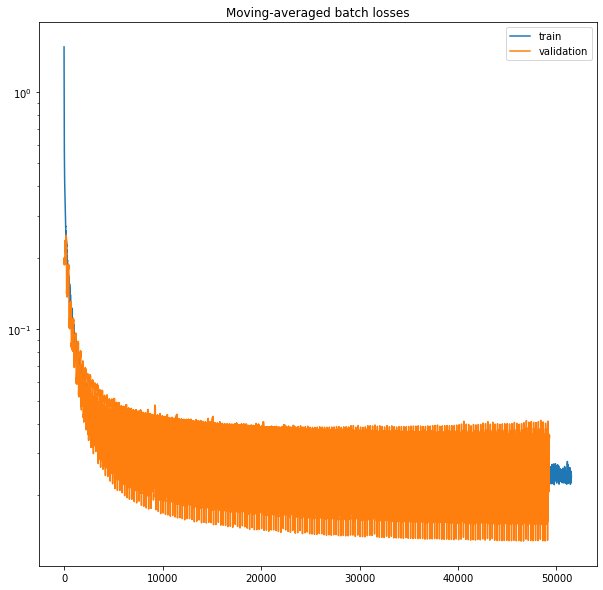

In [27]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [28]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

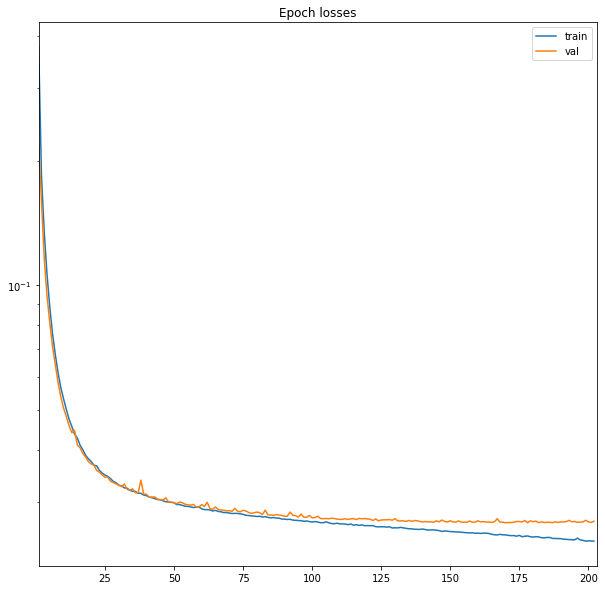

In [29]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [30]:
import pandas as pd

In [31]:
from visualization_utils import make_df

In [32]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.995771,0.941797,0.995515,0.967911,0.998262,0.937818,carb96558,basic
1,0.985112,0.892596,0.995707,0.941336,0.995080,0.889174,carb71,basic
2,0.979603,0.865344,0.954856,0.907899,0.977965,0.831332,carbRNF,basic
3,0.994422,0.990874,0.950316,0.970171,0.997810,0.942071,SPE_carb10_58_box3,basic
4,0.990749,0.947763,0.950095,0.948928,0.991718,0.902819,SoilAh-1,basic
5,0.993580,0.923924,0.993022,0.957227,0.997208,0.917964,SoilB-2,basic
6,0.990918,0.991227,0.948782,0.969540,0.996763,0.940881,TeTree_subset1,basic
7,0.994209,0.990008,0.957163,0.973309,0.996838,0.948005,TiTree_subset2,basic
8,0.990013,0.928600,0.995239,0.960766,0.997442,0.924494,Urna_22,basic
9,0.988843,0.946663,0.988770,0.967259,0.997750,0.936593,Urna_30,basic


In [33]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.9162
Std    IOU: 0.033825
Min    IOU: 0.83133
Median IOU: 0.92449


## Check loss to loss ratio

In [34]:
criterion.losses

(WeightedLoss(
   (loss): CrossEntropyLoss()
 ), WeightedLoss(
   (loss): DiceLoss()
 ))

In [35]:
from stack_segmentation.training import make_joint_loss

In [36]:
import torch

In [37]:
# loss_config[0] = {'loss': 'BCE',
#   'weight': 0.5,
#   'params': {}}
# loss_config
# crit = make_joint_loss(device=device, loss_config=loss_config)

In [38]:
crit = criterion
a = []
b = []
for i, (x, y) in enumerate(dataloader_val):
    if i > 100:
        break
    pred = model(torch.from_numpy(x).to(device))
    y = torch.from_numpy(y).to(device)
    a.append(crit.losses[0](pred, y).cpu().data.numpy())
    b.append(crit.losses[1](pred, y).cpu().data.numpy())

In [39]:
print('Mean 0 loss: {:.4f}\nMean 1 loss: {:.4f}\nMean of ratios: {:.4f}\nRatio of means: {:.4f}'
      .format(np.mean(a), np.mean(b), np.mean(np.array(a) / np.array(b)), np.mean(a) / np.mean(b)))

Mean 0 loss: 0.0135
Mean 1 loss: 0.0061
Mean of ratios: 2.2638
Ratio of means: 2.2106
